In [4]:
import pandas as pd

In [10]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt')

In [14]:
data.columns = ['Image.Var','Image.Skew','Image.Curt','Entropy','Class']
data.head()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
0,4.54590,8.1674,-2.4586,-1.46210,0
1,3.86600,-2.6383,1.9242,0.10645,0
2,3.45660,9.5228,-4.0112,-3.59440,0
3,0.32924,-4.4552,4.5718,-0.98880,0
4,4.36840,9.6718,-3.9606,-3.16250,0


In [15]:
import seaborn as sns
%matplotlib inline

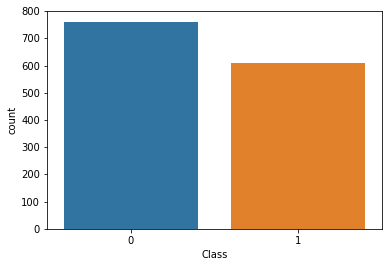

In [16]:
sns.countplot(x='Class',data=data)

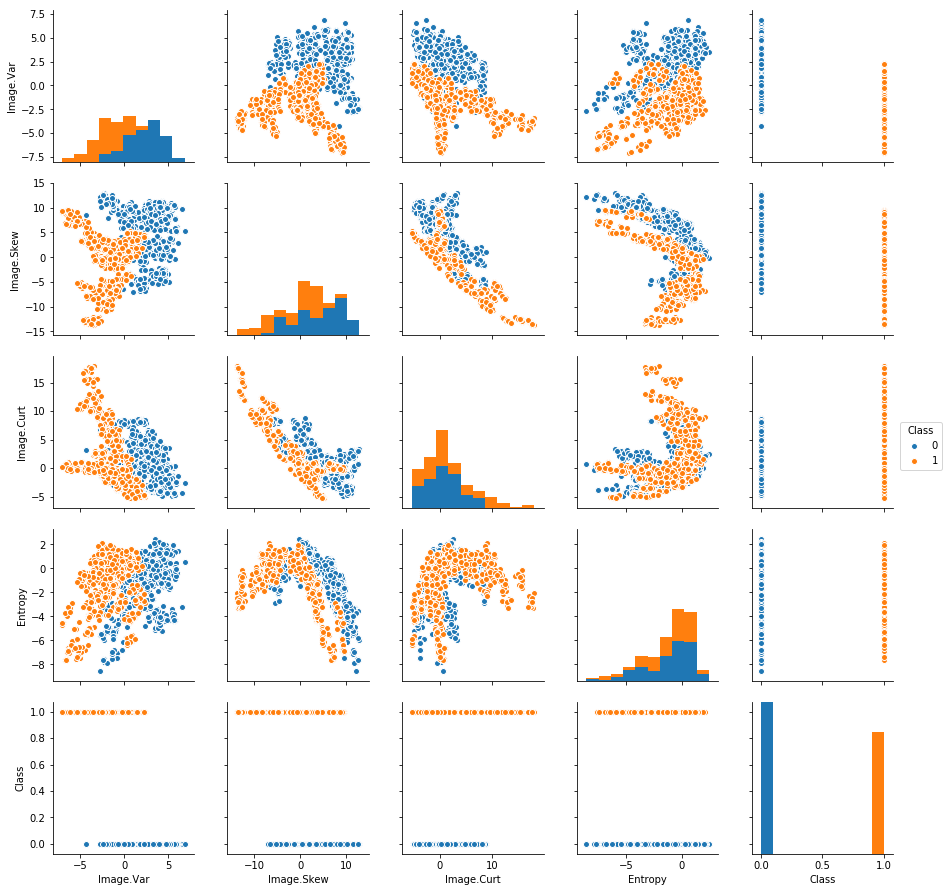

In [17]:
sns.pairplot(data,hue='Class')

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()

In [20]:
scaler.fit(data.drop('Class',axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
scaled_features = scaler.fit_transform(data.drop('Class',axis=1))

In [22]:
df_feat = pd.DataFrame(scaled_features,columns=data.columns[:-1])
df_feat.head()

,Image.Var,Image.Skew,Image.Curt,Entropy
0,1.448021,1.065417,-0.895733,-0.128468
1,1.208742,-0.776605,0.121504,0.618135
2,1.064661,1.296468,-1.256088,-1.143406
3,-0.035957,-1.086328,0.736006,0.096815
4,1.385553,1.321868,-1.244343,-0.937829


In [23]:
X = df_feat

In [24]:
y = data['Class']

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [28]:
df_feat.columns

Index(['Image.Var', 'Image.Skew', 'Image.Curt', 'Entropy'], dtype='object')

In [29]:
image_var = tf.feature_column.numeric_column("Image.Var")
image_skew = tf.feature_column.numeric_column('Image.Skew')
image_curt = tf.feature_column.numeric_column('Image.Curt')
entropy =tf.feature_column.numeric_column('Entropy')

In [30]:
feat_cols = [image_var,image_skew,image_curt,entropy]
feat_cols

[_NumericColumn(key='Image.Var', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Image.Skew', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Image.Curt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Entropy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [31]:
classifier = tf.estimator.DNNClassifier(hidden_units=[10, 20, 10], n_classes=2,feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/w1/p1j73rzn0v7brvqq15h5hf_40000gn/T/tmp127z6ktf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a30575b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=20,shuffle=True)

In [33]:
classifier.train(input_fn=input_func,steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/w1/p1j73rzn0v7brvqq15h5hf_40000gn/T/tmp127z6ktf/model.ckpt.
INFO:tensorflow:loss = 13.904766, step = 1
INFO:tensorflow:Saving checkpoints for 48 into /var/folders/w1/p1j73rzn0v7brvqq15h5hf_40000gn/T/tmp127z6ktf/model.ckpt.
INFO:tensorflow:Loss for final step: 0.40194714.


In [34]:
pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=len(X_test),shuffle=False)

In [35]:
note_predictions = list(classifier.predict(input_fn=pred_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/w1/p1j73rzn0v7brvqq15h5hf_40000gn/T/tmp127z6ktf/model.ckpt-48
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [36]:
note_predictions[0]

{'logits': array([4.50162], dtype=float32),
 'logistic': array([0.98903066], dtype=float32),
 'probabilities': array([0.01096935, 0.98903066], dtype=float32),
 'class_ids': array([1]),
 'classes': array([b'1'], dtype=object)}

In [37]:
final_preds  = []
for pred in note_predictions:
    final_preds.append(pred['class_ids'][0])

In [38]:
from sklearn.metrics import classification_report,confusion_matrix

In [39]:
print(confusion_matrix(y_test,final_preds))

[[214   5]
 [  0 193]]


In [40]:
print(classification_report(y_test,final_preds))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       219
          1       0.97      1.00      0.99       193

avg / total       0.99      0.99      0.99       412



In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rfc = RandomForestClassifier(n_estimators=200)

In [43]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
rfc_preds = rfc.predict(X_test)

In [45]:
print(classification_report(y_test,rfc_preds))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       219
          1       1.00      0.99      1.00       193

avg / total       1.00      1.00      1.00       412



In [46]:
print(confusion_matrix(y_test,rfc_preds))

[[219   0]
 [  1 192]]
